In [1]:
from functools import partial
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from auxiliary import plot_bandwidth
from auxiliary import plot_logistic

In [2]:
df= pd.read_stata("individ_final.dta")
df.index.set_names("identifier", inplace= True)
df.head()
df.replace({"outcomenext": {-1: np.nan}}, inplace= True)

In [3]:
df["bin"] = pd.cut(df["difshare"], 400, labels=False) / 200 - 1
df.sort_values(by="bin", inplace=True)
df.head()


,year,outcome,outcomenext,difshare,bin
identifier,,,,,
16420,1950,0,NaN,-0.999865,-1.0
17790,1964,0,NaN,-0.999738,-1.0
17789,1964,0,NaN,-0.999738,-1.0
17788,1964,0,NaN,-0.999738,-1.0
17787,1964,0,NaN,-0.999738,-1.0


In [4]:
df["outcomenext"].isna().sum()
# number of missing values in outcome variable

np.int64(16403)

In [5]:
# remove these missing variables
df.dropna(inplace= True)
np.testing.assert_equal(df["outcomenext"].isna().sum(), 0)

<Axes: xlabel='bin'>

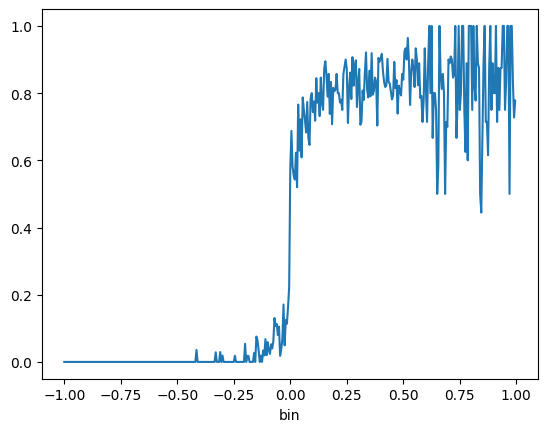

In [6]:
# mean of outcome for each bin , loval average
df.groupby("bin").mean()["outcomenext"].sort_index().plot()

In [7]:
# split data at cutoff
df["status"]= None
df.loc[df["difshare"].between(-0.25, 0.25), "status"]= "below"
df.loc[df["difshare"].between(0,0.25), "status"]= "above"

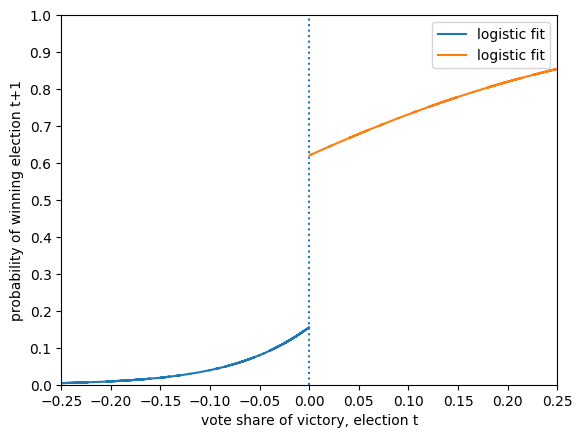

In [8]:
probs = dict()

lr = LogisticRegression(C=1e20)
for label in ["below", "above"]:

    df_subset = df.query(f"status == '{label}'")

    y = df_subset["outcomenext"]
    x = df_subset[["difshare"]]

    lr.fit(x, y)
    probs[label] = lr.predict_proba(x)

plot_logistic(df, probs)

In [9]:
# LLR as a method restricts the estimation to observations close to the cutoff. It is based on the assumption that regression lines within the bins around the cutoff point are close to linear. 
for h in [0.25, 0.2, 0.1, 0.05, 0.01]:
    df_subset = df[df["difshare"].between(-h, h)]
    formula = "outcomenext ~ outcome + difshare + difshare*outcome"
    rslt = smf.ols(formula=formula, data=df_subset).fit()
    info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
    print(" Bandwidth: {:>4}   Effect {:5.3f}%    pvalue {:5.3f}".format(*info))

 Bandwidth: 0.25   Effect 52.439%    pvalue 0.000
 Bandwidth:  0.2   Effect 49.521%    pvalue 0.000
 Bandwidth:  0.1   Effect 43.861%    pvalue 0.000
 Bandwidth: 0.05   Effect 38.910%    pvalue 0.000
 Bandwidth: 0.01   Effect 25.700%    pvalue 0.069


C:\Users\Devisha\AppData\Local\Temp\ipykernel_25752\2491597995.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
C:\Users\Devisha\AppData\Local\Temp\ipykernel_25752\2491597995.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
C:\Users\Devisha\AppData\Local\Temp\ipykernel_25752\2491597995.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [10]:
# optimal bandwidth is then a value of h that minimizes the mean square of the difference between the predicted and actual values of  Y
num_points= 10
bandwidth= np.linspace(0.01, 0.25, num_points)
scoring= "neg_mean_squared_error"
model= LinearRegression()
cv= LeaveOneOut()
cross_val_score_partial= partial(cross_val_score,scoring= scoring, cv=cv)

In [11]:
rslts = pd.DataFrame(columns=["below", "above", "joint"])
rslts.index.set_names("Bandwidth", inplace=True)

for label in ["below", "above"]:
    for h in bandwidth:

        if label == "below":
            df_subset = df.loc[df["difshare"].between(-h, +0.00)]
        else:
            df_subset = df.loc[df["difshare"].between(+0.00, +h)]

        y = df_subset[["outcomenext"]]
        x = df_subset[["difshare"]]

        rslts.loc[h, label] = -cross_val_score_partial(model, x, y).mean()

rslts["joint"] = rslts[["below", "above"]].mean(axis=1)

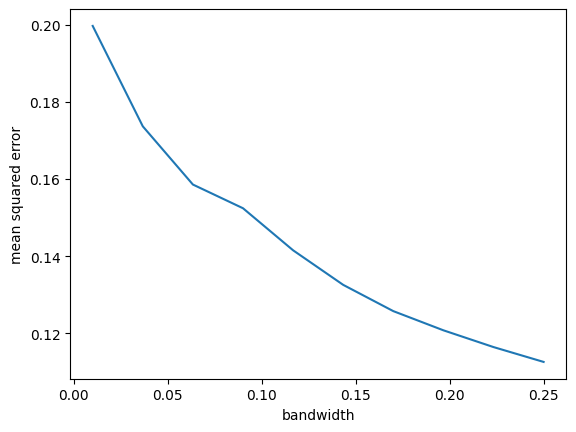

In [12]:
plot_bandwidth(bandwidth, rslts["joint"])

In [13]:
print(f" Optimal bandwidth: {rslts['joint'].idxmin():5.3f}")

 Optimal bandwidth: 0.250
